In [ ]:
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
import torchvision.transforms as transforms
from file_util import load_frame_obj
from pathlib import Path

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

In [43]:
device = torch.device("cuda:0")
device = torch.device('cpu')

mesh = load_frame_obj(Path('../data/dancing'), frame=1, device=device)

In [44]:
R, T = look_at_view_transform(dist=2, azim=0, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60).cpu()

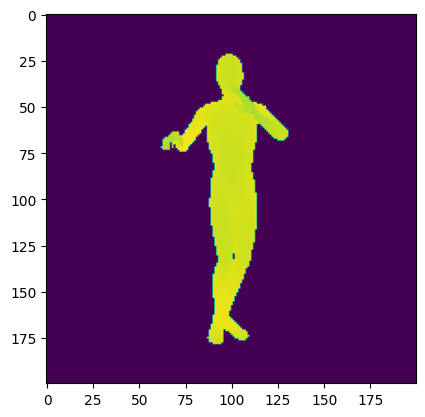

In [45]:
from rendering import rasterize

res = 200
fragments, depth_map = rasterize(cameras, mesh, res)

plt.imshow(depth_map)


In [58]:
feature_tensor = torch.zeros(100, 100, 3)

# feature_tensor[0]

In [ ]:
from util import project_feature_map_to_vertices

vertex_features = project_feature_map_to_vertices(
    mesh,
    cameras,
    depth_map,
    feature_tensor
)

# face_vert_features = mesh.faces_list()[0]
face_vert_features = vertex_features[mesh.faces_list()[0]]

In [ ]:
from rendering import rasterize_vertex_features

R, T = look_at_view_transform(dist=2, azim=220, elev=0)
cam2 = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60).cpu()

pixel_features = rasterize_vertex_features(cam2, mesh, res, vertex_features)

plt.imshow(pixel_features)


In [ ]:
image = Image.open('data/example/view.png').resize((res, res))
feature_tensor = to_tensor(image).permute(1, 2, 0)

In [ ]:
import rerun as rr
import rerun_util as ru

rr.init('debug', spawn=True)
rr.log('/', rr.ViewCoordinates.LUF, static=True)
rr.log('/', rr.Transform3D())

rr.log('cam', ru.pt3d_FovCamera(cameras, 0, res=res))
cam_trans = cameras.get_world_to_view_transform().inverse()
rr.log('cam', ru.pt3d_transform(cam_trans))
rr.log('cam', rr.Image(depth_map.cpu().numpy()))

# log mesh
rr.log("mesh", ru.pt3d_mesh(mesh, vertex_colors=vertex_colors))
